In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

from sklearn import preprocessing

from sklearn import tree
from sklearn.feature_extraction.text import CountVectorizer
import pickle as pkl

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split


from sklearn.pipeline import make_pipeline

In [2]:
df = pd.read_json('model_dataset.json')
df.head()

,artist,channelId,channel_subCount,channel_viewCount,search_keyword,song_title,title_on_youtube,up_time,video_id,video_viewCount,y
0,Post Malone,UCOhtMAg7xh8wv_wUHMgFc-Q,4152281,2423719656,rockstar (feat. 21 Savage) - Post Malone,rockstar (feat. 21 Savage),post malone - rockstar ft. 21 savage,390,UceaB4D0jpo,449680363,1
1,Above & Beyond,UCVE-ybBDg3UHSUylEVdPAsw,601202,196598047,All Over the World (feat. Alex Vargas) - Above...,All Over the World (feat. Alex Vargas),"above & beyond feat. alex vargas - ""all over t...",1439,U-zC8BkPBZM,1931778,1
2,MAN WITH A MISSION,UCCy_q-N7F2FOIZ6ZggHIAKg,1387084,1583887822,Find You - MAN WITH A MISSION,Find You,man with a mission 『find you』,373,rYS9ZdGt9Ko,1340627,1
3,Wally Ballago Seck,UCVZXJLPHbOADqiup8XqKcLA,15217,8795785,Bodioudo - Wally Ballago Seck,Bodioudo,wally ballago seck - bo dioudo,1839,E5XzF4c1Lw8,117098,1
4,Ben Howard,UCFS0CJgXUt7NjwrUN--vFRg,209566,101654143,Nica Libres At Dusk - Ben Howard,Nica Libres At Dusk,ben howard - nica libres at dusk,208,NzcV8HXE_EI,1624752,1


In [3]:
def quick_analysis(df):
    print('Data Types:')
    print(df.dtypes)
    print('Rows and Columns:')
    print(df.shape)
    print('Column Names:')
    print(df.columns)
    print('Null Values:')
    print(df.apply(lambda x: sum(x.isnull()) / len(df)))
quick_analysis(df)

Data Types:
artist               object
channelId            object
channel_subCount      int64
channel_viewCount     int64
search_keyword       object
song_title           object
title_on_youtube     object
up_time               int64
video_id             object
video_viewCount       int64
y                     int64
dtype: object
Rows and Columns:
(3933, 11)
Column Names:
Index(['artist', 'channelId', 'channel_subCount', 'channel_viewCount',
       'search_keyword', 'song_title', 'title_on_youtube', 'up_time',
       'video_id', 'video_viewCount', 'y'],
      dtype='object')
Null Values:
artist               0.0
channelId            0.0
channel_subCount     0.0
channel_viewCount    0.0
search_keyword       0.0
song_title           0.0
title_on_youtube     0.0
up_time              0.0
video_id             0.0
video_viewCount      0.0
y                    0.0
dtype: float64


In [4]:
#Set the threshold = 3*z-score, all the data have z > threshold are outliers. (imperical rules)
#z = np.abs(stats.zscore(df[['channel_subCount', 'channel_viewCount','video_viewCount']]))

In [5]:
#threshold = 3
#df = df[(z < 3).all(axis=1)]

## Labels' composition 

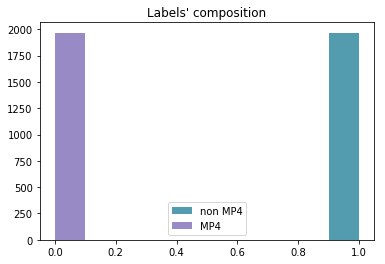

In [6]:
def overlaid_histogram(data1, data2, n_bins = 0, data1_name="", data1_color="#539caf", data2_name="", data2_color="#7663b0", x_label="", y_label="", title=""):
    # Set the bounds for the bins so that the two distributions are fairly compared
    max_nbins = 10
    data_range = [min(min(data1), min(data2)), max(max(data1), max(data2))]
    binwidth = (data_range[1] - data_range[0]) / max_nbins


    if n_bins == 0:
        bins = np.arange(data_range[0], data_range[1] + binwidth, binwidth)
    else: 
        bins = n_bins

    # Create the plot
    _, ax = plt.subplots()
    ax.hist(data1, bins = bins, color = data1_color, alpha = 1, label = data1_name)
    ax.hist(data2, bins = bins, color = data2_color, alpha = 0.75, label = data2_name)
    ax.set_ylabel(y_label)
    ax.set_xlabel(x_label)
    ax.set_title(title)
    ax.legend(loc = 'best')

overlaid_histogram(df[df.y ==1].y, df[df.y !=1].y, x_label="", y_label="", title="Labels' composition", data1_name = 'non MP4', data2_name = 'MP4')

# 1. Generally, MP4 has higher views than non MP4 version

## Visualize mp4 features

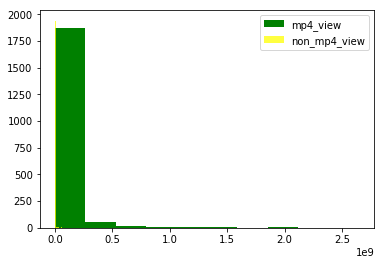

In [7]:
_,ax = plt.subplots()
ax.hist(df[df.y ==1].video_viewCount, color = 'green', alpha = 1, label = 'mp4_view')
ax.hist(df[df.y !=1].video_viewCount, color = 'yellow', alpha = 0.75, label = 'non_mp4_view')
ax.legend(loc = 'best')

plt.show()



This feature's data is hyper right skewed. For better performance of model, we transformed the data using log to normal distribution of data.

In [8]:
df['log_view'] = np.log((1+df.video_viewCount))

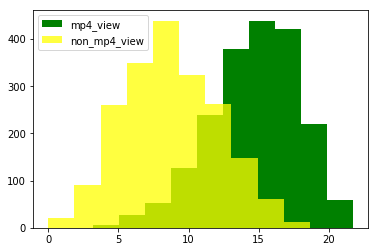

In [9]:
_,ax = plt.subplots()
ax.hist(df[df.y ==1].log_view, color = 'green', alpha = 1, label = 'mp4_view')
ax.hist(df[df.y !=1].log_view, color = 'yellow', alpha = 0.75, label = 'non_mp4_view')
ax.legend(loc = 'best')

plt.show()

Normally, MP4 version have more view than others type.

## Sentiment analysis on text features

In [10]:
from sklearn.feature_extraction.text import CountVectorizer 

In [11]:
## DESCRIBE ENGLISH_STOP_WORDS
# This list of English stop words is taken from the "Glasgow Information
# Retrieval Group". The original list can be found at
# http://ir.dcs.gla.ac.uk/resources/linguistic_utils/stop_words
# ADDED SOME WORDS : (FT, FEAT) WHICH ARE COMMON IN SONGS' TITLE

ENGLISH_STOP_WORDS = frozenset(["a", "about", "above", "across", "after", "afterwards", "again", "against",
    "all", "almost", "alone", "along", "already", "also", "although", "always",
    "am", "among", "amongst", "amoungst", "amount", "an", "and", "another",
    "any", "anyhow", "anyone", "anything", "anyway", "anywhere", "are",
    "around", "as", "at", "back", "be", "became", "because", "become",
    "becomes", "becoming", "been", "before", "beforehand", "behind", "being",
    "below", "beside", "besides", "between", "beyond", "bill", "both",
    "bottom", "but", "by", "call", "can", "cannot", "cant", "co", "con",
    "could", "couldnt", "cry", "de", "describe", "detail", "do", "done",
    "down", "due", "during", "each", "eg", "eight", "either", "eleven", "else",
    "elsewhere", "empty", "enough", "etc", "even", "ever", "every", "everyone",
    "everything", "everywhere", "except", "few","ft",'feat',"features", "fifteen", "fifty", "fill",
    "find", "fire", "first", "five", "for", "former", "formerly", "forty",
    "found", "four", "from", "front", "full", "further", "get", "give", "go",
    "had", "has", "hasnt", "have", "he", "hence", "her", "here", "hereafter",
    "hereby", "herein", "hereupon", "hers", "herself", "him", "himself", "his",
    "how", "however", "hundred", "i", "ie", "if", "in", "inc", "indeed",
    "interest", "into", "is", "it", "its", "itself", "keep", "last", "latter",
    "latterly", "least", "less", "ltd", "made", "many", "may", "me",
    "meanwhile", "might", "mill", "mine", "more", "moreover", "most", "mostly",
    "move", "much", "must", "my", "myself", "name", "namely", "neither",
    "never", "nevertheless", "next", "nine", "no", "nobody", "none", "noone",
    "nor", "not", "nothing", "now", "nowhere", "of", "off", "often", "on",
    "once", "one", "only", "onto", "or", "other", "others", "otherwise", "our",
    "ours", "ourselves", "out", "over", "own", "part", "per", "perhaps",
    "please", "put", "rather", "re", "same", "see", "seem", "seemed",
    "seeming", "seems", "serious", "several", "she", "should", "show", "side",
    "since", "sincere", "six", "sixty", "so", "some", "somehow", "someone",
    "something", "sometime", "sometimes", "somewhere", "still", "such",
    "system", "take", "ten", "than", "that", "the", "their", "them",
    "themselves", "then", "thence", "there", "thereafter", "thereby",
    "therefore", "therein", "thereupon", "these", "they", "thick", "thin",
    "third", "this", "those", "though", "three", "through", "throughout",
    "thru", "thus", "to", "together", "too", "top", "toward", "towards",
    "twelve", "twenty", "two", "un", "under", "until", "up", "upon", "us",
    "very", "via", "was", "we", "well", "were", "what", "whatever", "when",
    "whence", "whenever", "where", "whereafter", "whereas", "whereby",
    "wherein", "whereupon", "wherever", "whether", "which", "while", "whither",
    "who", "whoever", "whole", "whom", "whose", "why", "will", "with",
    "within", "without", "would", "yet", "you", "your", "yours", "yourself",
    "yourselves"])

In [12]:
title_words = list(df.title_on_youtube.values)

In [13]:
title_words[:10]

['post malone - rockstar ft. 21 savage',
 'above & beyond feat. alex vargas - "all over the world" (official music video)',
 'man with a mission 『find you』',
 'wally ballago seck - bo dioudo',
 'ben howard - nica libres at dusk',
 'john mellencamp - key west intermezzo (i saw you first)',
 'morcheeba - trigger hippie (official video)',
 'lea rue - sleep, for the weak! (lost frequencies remix)',
 "can't get it out of my head - jeff lynne (acoustic)",
 'g-eazy - the plan (official music video)']

In [14]:
count_vec = CountVectorizer(stop_words= ENGLISH_STOP_WORDS, analyzer='word', 
                            ngram_range=(1, 3), max_df=1.0, min_df=1, max_features=8)

In [15]:
count_vec.fit(title_words)

#print(count_vec.get_feature_names())

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=8, min_df=1,
        ngram_range=(1, 3), preprocessor=None,
        stop_words=frozenset({'neither', 'three', 'elsewhere', 'whenever', 'still', 'though', 'after', 'about', 'even', 'whatever', 'will', 'eight', 'thence', 'then', 'been', 'against', 'again', 'either', 'several', 'never', 'un', 'in', 'while', 'enough', 'over', 'mostly', 'something', 'itself', 'interest',... 'couldnt', 'such', 'where', 'twelve', 'features', 'than', 'at', 'yet', 'others', 'whom', 'seemed'}),
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [57]:
sentiment_file_name = 'sentiment_countvectorizer.sav'
pkl.dump( count_vec, open(sentiment_file_name, 'wb'))

In [16]:
count_vec.get_feature_names()

['audio',
 'music',
 'music video',
 'official',
 'official music',
 'official music video',
 'official video',
 'video']

In [17]:
a  = count_vec.transform(title_words)

In [18]:
a.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 1, 1, ..., 1, 0, 1],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [19]:
df = df[['channel_subCount','channel_viewCount','title_on_youtube','up_time','log_view','y']].reset_index()
df.head()

,index,channel_subCount,channel_viewCount,title_on_youtube,up_time,log_view,y
0,0,4152281,2423719656,post malone - rockstar ft. 21 savage,390,19.924048,1
1,1,601202,196598047,"above & beyond feat. alex vargas - ""all over t...",1439,14.473952,1
2,2,1387084,1583887822,man with a mission 『find you』,373,14.108649,1
3,3,15217,8795785,wally ballago seck - bo dioudo,1839,11.670775,1
4,4,209566,101654143,ben howard - nica libres at dusk,208,14.300866,1


In [20]:
sentiment_df = pd.DataFrame(a.toarray(), columns = count_vec.get_feature_names())

In [21]:
sentiment_df.head()

,audio,music,music video,official,official music,official music video,official video,video
0,0,0,0,0,0,0,0,0
1,0,1,1,1,1,1,0,1
2,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0


In [22]:
df_merge = pd.concat([df, sentiment_df], axis = 1, ignore_index = False )

In [23]:
df_merge.drop(['index'], axis = 1, inplace = True)

In [24]:
df_merge.head()

,channel_subCount,channel_viewCount,title_on_youtube,up_time,log_view,y,audio,music,music video,official,official music,official music video,official video,video
0,4152281,2423719656,post malone - rockstar ft. 21 savage,390,19.924048,1,0,0,0,0,0,0,0,0
1,601202,196598047,"above & beyond feat. alex vargas - ""all over t...",1439,14.473952,1,0,1,1,1,1,1,0,1
2,1387084,1583887822,man with a mission 『find you』,373,14.108649,1,0,0,0,0,0,0,0,0
3,15217,8795785,wally ballago seck - bo dioudo,1839,11.670775,1,0,0,0,0,0,0,0,0
4,209566,101654143,ben howard - nica libres at dusk,208,14.300866,1,0,0,0,0,0,0,0,0


Label verified channel and not verified channel (according to channel_subCount ~ 10e5)

In [25]:
df_merge.channel_subCount = df_merge.channel_subCount.apply(lambda row: 1 if row >= 100000 else 0)

In [26]:
df_merge.drop(['channel_viewCount','title_on_youtube'], axis =1, inplace = True)

In [27]:
df_merge.head()

,channel_subCount,up_time,log_view,y,audio,music,music video,official,official music,official music video,official video,video
0,1,390,19.924048,1,0,0,0,0,0,0,0,0
1,1,1439,14.473952,1,0,1,1,1,1,1,0,1
2,1,373,14.108649,1,0,0,0,0,0,0,0,0
3,0,1839,11.670775,1,0,0,0,0,0,0,0,0
4,1,208,14.300866,1,0,0,0,0,0,0,0,0


# FEATURES CORRELATION HEATMAP

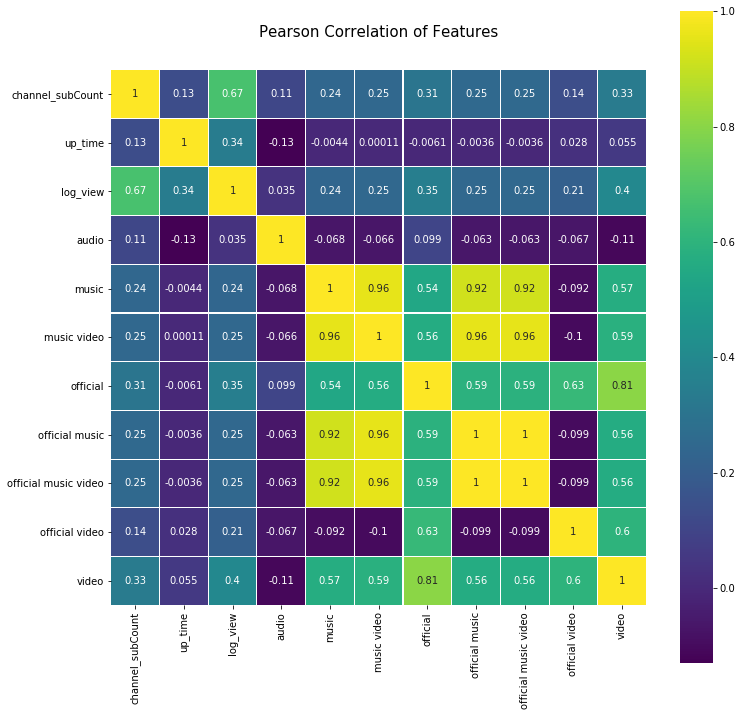

In [28]:
colormap = plt.cm.viridis
plt.figure(figsize=(12,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(df_merge.drop(['y'], axis =1).corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

In [29]:
#df_merge['view_per_day'] = df_merge.video_viewCount / df.up_time 

In [30]:
#df_merge.drop(['video_viewCount','up_time'], axis =1, inplace = True)
#df_merge.head()

In [31]:
#mp4_view_day = df_merge[df_merge.y == 1].view_per_day

In [32]:
X_train, X_test, y_train, y_test = train_test_split(df_merge.drop(['y'], axis = 1), df_merge.y, test_size= 0.2, random_state=13)

In [33]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(3146, 11)
(3146,)
(787, 11)
(787,)


In [34]:
from sklearn.tree import DecisionTreeClassifier

In [35]:
tree = DecisionTreeClassifier()

In [36]:
tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [37]:
tree.score(X_test, y_test)

0.8221092757306226

In [38]:
test_array = list(count_vec.transform(['EXO 엑소 "Love Shot" MV']).toarray()[0])

In [39]:
#tree.predict(np.array(test_2).reshape(1, -1))

In [40]:
### Try different combination of params before the final_model

# FINAL MODEL

In [41]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=10, max_features = 3)
# Train
model.fit(X_train, y_train)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=3, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [42]:
y_pred = model.predict(X_test)
y_pred

array([1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0,
       1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
       1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0,
       1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0,

# METRICS REPORT

In [43]:
from sklearn.metrics import confusion_matrix

In [44]:
confusion_matrix(y_test, y_pred)

array([[335,  37],
       [ 76, 339]], dtype=int64)

AS we can see that, there is 37 FALSE POSITIVE(FP) and 76 FALSE NEGATIVE (FN)  
This indicated that the model more likely misclassified non_mp4 to mp4 

In [45]:
from sklearn.metrics import classification_report

In [46]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.82      0.90      0.86       372
          1       0.90      0.82      0.86       415

avg / total       0.86      0.86      0.86       787



INSPECT WHICH DATA THAT MODEL IS LIKELY to misclassify

In [47]:
wrong_results = X_test[y_pred != y_test]
wrong_index = list(wrong_results.index)
df.iloc[wrong_index].to_csv('wrong_type.csv')


In [48]:
df.to_csv('full_model_data.csv')

In [49]:
model.predict_proba(np.array(df_merge.drop('y',axis =1).iloc[2776].values).reshape(1,-1))

array([[0.2, 0.8]])

In [50]:
model.predict_proba(np.array([1,700,np.log(2.5e6),0,0,0,0,0,0,0,0]).reshape(1,-1))

array([[0., 1.]])

In [51]:
df.iloc[2776]

index                           2776
channel_subCount               20781
channel_viewCount           11130274
title_on_youtube     bubblegum bitch
up_time                          691
log_view                     13.4869
y                                  0
Name: 2776, dtype: object

In [52]:
df_merge.iloc[2776]

channel_subCount          0.000000
up_time                 691.000000
log_view                 13.486911
y                         0.000000
audio                     0.000000
music                     0.000000
music video               0.000000
official                  0.000000
official music            0.000000
official music video      0.000000
official video            0.000000
video                     0.000000
Name: 2776, dtype: float64

AFTER review input data, we regconise that some label in the input data set is wrong which lead to mis classify of model.  
We need to check the input dataset before retrain the model.

After testing model on numerous combination of features, this model is the most accurate with feature :  
    -channel_subCount  
    -up_time  
    -video_viewCount  
    -music video  
    -official audio  
    -official music  
    -official music video  
    -official video  

# TODO: Create visualizer of Decision Tree process 

In [53]:
from sklearn.tree import export_graphviz
estimator = model.estimators_[5]
# Export as dot file
export_graphviz(estimator, 
                out_file='tree.dot', 
                feature_names = X_train.columns,
                class_names = ['0','1'],
                rounded = True, proportion = False, 
                precision = 2, filled = True)

In [55]:
#from subprocess import check_call
#check_call(['dot','-Tpng','tree.dot','-o','tree.png'])

In [ ]:
import graphviz
graphviz.Source.from_file('tree.dot')

## Done

# EXPORT MODEL

In [ ]:
file_name = 'RandomForest_classifier.sav'
pkl.dump(model, open(file_name, 'wb'))

# TODO: Optimize features and Apply different models

In [59]:
vector = pkl.load(open(sentiment_file_name,'rb'))

In [60]:
vector.get_feature_names()

['audio',
 'music',
 'music video',
 'official',
 'official music',
 'official music video',
 'official video',
 'video']